<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#quick-start" data-toc-modified-id="quick-start-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>quick start</a></span><ul class="toc-item"><li><span><a href="#Resources" data-toc-modified-id="Resources-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Resources</a></span></li></ul></li><li><span><a href="#FULL-MODEL" data-toc-modified-id="FULL-MODEL-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>FULL MODEL</a></span><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Packages</a></span><ul class="toc-item"><li><span><a href="#Qnetwork" data-toc-modified-id="Qnetwork-2.1.1"><span class="toc-item-num">2.1.1&nbsp;&nbsp;</span>Qnetwork</a></span></li></ul></li><li><span><a href="#POMDP-RNN-Game" data-toc-modified-id="POMDP-RNN-Game-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>POMDP RNN Game</a></span></li><li><span><a href="#Results" data-toc-modified-id="Results-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Results</a></span><ul class="toc-item"><li><span><a href="#Standard-setting：-grid-=--(3,7)，-holes-=-0" data-toc-modified-id="Standard-setting：-grid-=--(3,7)，-holes-=-0-2.3.1"><span class="toc-item-num">2.3.1&nbsp;&nbsp;</span>Standard setting： grid =  (3,7)， holes = 0</a></span></li><li><span><a href="#Model-Tranining" data-toc-modified-id="Model-Tranining-2.3.2"><span class="toc-item-num">2.3.2&nbsp;&nbsp;</span>Model Tranining</a></span></li><li><span><a href="#decoding-vs-performance" data-toc-modified-id="decoding-vs-performance-2.3.3"><span class="toc-item-num">2.3.3&nbsp;&nbsp;</span>decoding vs performance</a></span></li><li><span><a href="#learning-rate-vs-performance" data-toc-modified-id="learning-rate-vs-performance-2.3.4"><span class="toc-item-num">2.3.4&nbsp;&nbsp;</span>learning rate vs performance</a></span></li><li><span><a href="#Summary" data-toc-modified-id="Summary-2.3.5"><span class="toc-item-num">2.3.5&nbsp;&nbsp;</span>Summary</a></span></li><li><span><a href="#Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why" data-toc-modified-id="Anlytic-part-,-check-the-behaviour-correspond-to-each-decoding-level-and-explain-why-2.3.6"><span class="toc-item-num">2.3.6&nbsp;&nbsp;</span>Anlytic part , check the behaviour correspond to each decoding level and explain why</a></span></li></ul></li><li><span><a href="#PCA" data-toc-modified-id="PCA-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>PCA</a></span></li></ul></li></ul></div>

# quick start 

The dynamics is shown to be line atttractors.  But how this attractor is used?  What is relation between them and real game dynamics?  

## Resources

* [*The* Reinforcement learning book from Sutton & Barto](http://incompleteideas.net/sutton/book/the-book-2nd.html)
* [The REINFORCE paper from Ronald J. Williams (1992)](http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf)


# FULL MODEL

## Packages

In [ ]:
%load_ext autoreload
%autoreload 2

import numpy as np
from itertools import count
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from torch.autograd import Variable
from torch.nn import init
from torch.nn import DataParallel
from torch.utils.data import DataLoader

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import matplotlib.animation
import seaborn as sns
from IPython.display import HTML

import pretrain
from pretrain import *

import pandas as pd

import navigation2
from navigation2 import *

import sklearn
from sklearn.svm import SVC

import scipy
from scipy.spatial import distance
from scipy import signal

import Nets 
from Nets import *

import dynamics
from dynamics import * 

import GLM
from GLM import *

from mpl_toolkits.mplot3d import Axes3D  

%pylab inline
import warnings
warnings.filterwarnings('ignore')

### Pretrained network
Record the relaxation to line attractor by setting on the averaged action for different steps(T=2 for initially, T=100 for more.

How much variance is caused action, how much is caused by action itself? 

Measure velocity with null actions and with full actions, compare the velocity caused by action and remaing velocity,  it might reveals the dh/dt = ah + bA with a and b measured.   

If with null action speed not goes to 0, think how the given dynamical structures gives the position components, does it still effective to say that with action is fast direction, null action is slow direction

In [ ]:
class slowmanifold():
    def __init__(self, weight):
        self.weight = weight
        self.pca = PCA(weight, size = 15)
        
    def Simulations(self, k_action = 1, epsilon = 0, size = 15, T = 200, seed_num = 1e3, reward_control = None):
        PC_traces = []
        Hiddens = []
        Poss = []
        Actions = []
        States = []
        Context = []
        for i in range(T):
            torch.manual_seed(np.random.randint(seed_num))
            hidden0 = torch.randn(1, 512)
            if reward_control == None:
                c  = np.random.randint(2)
            else:
                c = reward_control
            start = (np.random.randint(2, size +2),  np.random.randint(2, size+2))
            game = ValueMaxGame(grid_size = (size, size), holes = 0, random_seed = 0 , set_reward = [(0.5, 0.25), (0.5, 0.75)], input_type = 0, discount = 0.9, alpha = 1
                               ,lam = 0)
            game.net.load_state_dict(torch.load(self.weight))
            game.net.k_action = k_action 
            grid = game.grid.grid.copy()
            Pos, hidden, dh, Action, State, reward = trajectory(game, start, reward_control = c, size = size, \
                                                                      test = 0, limit_set = 4, init_hidden = False, hidden = hidden0, epsilon = epsilon)
            Hiddens.append(hidden)
            Poss.append(Pos[1:])
            Actions.append(Action)
            States.append(State)
            Context.append(c * np.ones(len(State)))
        return States, Poss, Hiddens, Actions, Context   
    
    def Transform(self, States, Poss, Hiddens, Actions, Context, 
                  history = False, stages = False, size = 15):
    # last click state
        Status = np.concatenate([State_transform(state, poss, size) for state, poss in zip(States, Poss)])
        Stages = np.concatenate([Stage_transform(state) for state in States])
        Hiddens = np.concatenate(Hiddens)
        Poss = np.concatenate(Poss)
        Actions = np.concatenate(Actions)
        Context = np.concatenate(Context)
        # transform state to stim　
        States = np.concatenate(States)
        # transform status to memory
        Memory = history_summary(Status)
        set_ = set([tuple(s) for s in States])
        dict_ = {}
        for i, s in enumerate(set_): 
            dict_.update({s:i})
        Stim = [dict_[tuple(s)] for s in States] 
        set_ = set([tuple(m) for m in Memory])
    #     dict_ = {}
    #     for i, m in enumerate(set_): 
    #         dict_.update({m:i})
    #     Mem = [dict_[tuple(m)] for m in Memory] 
        return Stages, States, Poss, Hiddens, Actions, Status, Context, Memory 

        
    def pca_record(self):
        self.pca.pca(T_duration = 5)
        
    def data_record(self, epsilon = 0.5, T = 500):
        States, Poss, Hiddens, Actions, Context = self.Simulations(k_action = 1, epsilon = epsilon, size = 15, T = T, seed_num = 1e3, reward_control = 0)
        Stages, States, Poss, Hiddens, Actions, Status, Context, Memory = self.Transform(States, Poss, Hiddens, Actions, Context, stages = True, size = 15)
        self.States = States
        self.Poss = Poss
        self.Hiddens = Hiddens
        self.Actions = Actions
        self.Status = Status
        self.Context = Context
        self.Memory = Memory 
        self.Stages = Stages
        
    def manifold_record(self, T_slow = 5):
#         Hiddens0 = self.Hiddens[self.Status == status]
        Hidden1 = []
        Hiddens1 = []
        Velocity0 = []
        Velocity1 = []
        Pos_r = [(9, 5), (9, 13)]
        for hidden0, c, a in zip(self.Hiddens, self.Context, self.Actions):
            context = self.pca.game.placefield(Pos_r[int(c)])
            hidden0 = torch.from_numpy(hidden0).type(torch.FloatTensor)
            velocity0 = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = a)
            Velocity0.append(velocity0)
            hidden0 = self.pca.relaxation(T = T_slow, hidden0 = hidden0, context = context)
            velocity = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = 4)
            Velocity1.append(velocity)
            Hidden1.append(hidden0)
            Hiddens1.append(self.pca.Hiddens)
        Hidden1 = np.array(Hidden1)
        Hiddens1 = np.array(Hiddens1)
        return Hidden1, Velocity0, Velocity1, Hiddens1
    
    def gradientdescent(self, hidden0, stim = torch.zeros(1, 9) , action = 4, iterations = 1):
        for i in range(int(iterations * 1e2)+1):
            hidden0 = Variable(hidden0,requires_grad=True)
            velocity = fixpoints(weight, hidden0, stim = stim, action = action)
            if i%500 == 0:
                print (i, velocity)
        #     print (hidden0.requires_grad)
            velocity.backward()
        #     print ('grad0', hidden0.grad[0][0])
            hidden0 = torch.add(hidden0, -1e-2 * (hidden0.grad))
            hidden0 = Variable(hidden0,requires_grad=True)
        return hidden0, velocity
    
    def manifold_record_2(self, T_slow = 100):
#         Hiddens0 = self.Hiddens[self.Status == status]
        Hidden1 = []
        Velocity0 = []
        Velocity1 = []
        Pos_r = [(9, 5), (9, 13)]
        for hidden0, c, a in zip(self.Hiddens, self.Context, self.Actions):
            context = self.pca.game.placefield(Pos_r[int(c)])
            hidden0 = torch.from_numpy(hidden0).type(torch.FloatTensor)
            velocity0 = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = a)
            Velocity0.append(velocity0)
            hidden0 = self.pca.relaxation(T = 2, hidden0 = hidden0, context = context)
            velocity = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = 4)
            Velocity1.append(velocity)
            Hidden1.append(hidden0)
        Hidden100 = []
        Velocity100 = []
        Pos_r = [(9, 5), (9, 13)]
        for hidden0, c in zip(self.Hiddens, self.Context):
            context = self.pca.game.placefield(Pos_r[int(c)])
            hidden0 = torch.from_numpy(hidden0).type(torch.FloatTensor)
            hidden0 = self.pca.relaxation(T = T_slow, hidden0 = hidden0, context = context)
            velocity = fixpoints(self.weight, hidden0, stim = torch.zeros(1, 9), action = 4)
            Velocity100.append(velocity)
            Hidden100.append(hidden0)
        Hidden1 = np.array(Hidden1)
        Hidden100 = np.array(Hidden100)
        return Hidden1, Hidden100, Velocity0, Velocity1, Velocity100
    

### Starting from random 

**color the slow manifold by stimulus memory and position, if the ring-like manifold corresponding to any structure**

# PosNet

# color the state space according to memory state, past history
Until now it seems the hidden states only record single history of last stimlus, which is reflected in line attractor behavoiur, which in constrast to claim of 2 clicks, It is well noticing the intrinsic manifold depending on exploration noise.  

Little noise limit, with noised increase , the intrinsic manifold dimension will increases, but it is never larger than the 2 for the slow relaxation and 3 for real state   

In [11]:
weight = 'weights_pos2/rnn_1515tanh512_checkpoint{}'.format(399)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)


In [12]:
Hiddens2 = Hiddens2.transpose(1, 0 ,2)

In [13]:
## calculate participation ratio

Cor = np.zeros((512, 512))
for h in Hiddens2[-1]:
    h = (h - np.mean(h))/np.std(h)
    h = h.reshape(1, 512)
    Cor += h.T @ h 
print (Cor)
lambdas, vs = np.linalg.eig(Cor)
np.sum(lambdas) ** 2/np.sum(lambdas** 2)

[[ 3459.17524466  -681.59291061  1098.13195558 ...  -423.49308822
   3583.58711925   705.31997464]
 [ -681.59291061  3201.48500289    92.30001459 ... -1424.99249474
  -3252.03139201  1386.33275973]
 [ 1098.13195558    92.30001459  2253.2423957  ...  1963.34865839
    801.44791256 -1533.34896146]
 ...
 [ -423.49308822 -1424.99249474  1963.34865839 ...  4495.78214658
     94.89436092 -3614.23878346]
 [ 3583.58711925 -3252.03139201   801.44791256 ...    94.89436092
   6776.50465147   -22.00392451]
 [  705.31997464  1386.33275973 -1533.34896146 ... -3614.23878346
    -22.00392451  3177.47698406]]


2.025939957935017

Study the relation between hidden states space and encoded variable x, y, s. As h can be represented by PC1-3 , then we need to find a function that goes from PC = f(x, y, s) also x, y, s = g(PC0,PC1, PC2)for both hidden states.  

In this analysis, I find about this structure in the following manner:  

Record all PCs for a lot of hidden state with their variables, do a supervised learnign as GLM with it.  Then use it to predict the real trajectories coordinates,  see if hte slow skelonton explains both encoding, decoding  

Because of the sliding,we cannot directly mapping the real state x , y to relaxed hidden states , they are not colliding together, another way of parameterisation need to be thought ,such as topology,  or order, or nearest neibours 

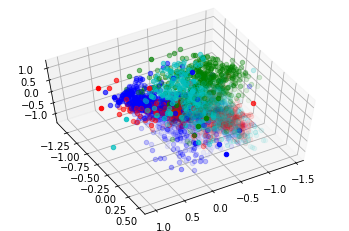

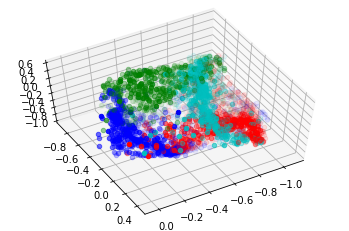

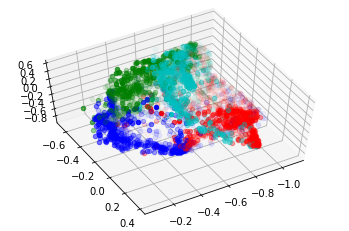

In [14]:
# colored by velocity,  which indicates the border 
colors = ['k', 'r', 'g', 'b', 'c']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[manifold.Status == k]):
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
for K in [1, 2]:        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for k in [1, 2, 3, 4]:
        V = np.array(Velocity0)[manifold.Status == k]
        V = [v.data.numpy().item() for v in V]

        for i, hidden in enumerate(Hiddens2[5 * K][manifold.Status == k]):
            ax.view_init(60, 60)
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                       hidden @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)
#         ax.scatter(Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[0], Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[1],
#                    Hidden1[manifold.Status == k][0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = 1, marker = 's', s = 80)
# fig = plt.figure()
# ax = fig.add_subplot(111, projection='3d')
# for k in [1, 2, 3, 4]:
#     V = np.array(Velocity0)[manifold.Status == k]
#     V = [v.data.numpy().item() for v in V]
    
#     for i, hidden in enumerate(Hidden2[manifold.Status == k]):
#         ax.view_init(60, 60)
#         ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1],
#                    hidden[0].data.numpy() @ manifold.pca.vect[2], color = colors[k], alpha = (V[i]/np.max(V))**2)

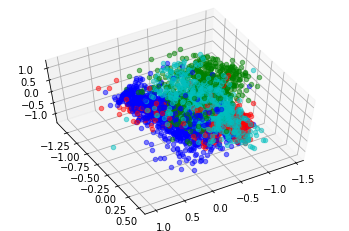

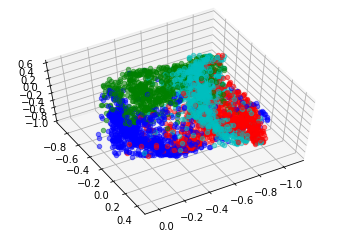

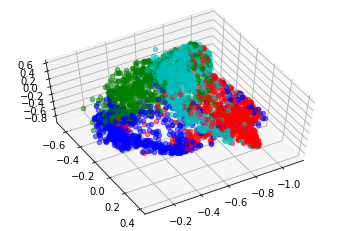

In [17]:
# no coloring on velocity   
colors = ['k', 'r', 'g', 'b', 'c']
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for k in [1, 2, 3, 4]:
    V = np.array(Velocity0)[manifold.Status == k]
    V = [v.data.numpy().item() for v in V]
    
    for i, hidden in enumerate(manifold.Hiddens[manifold.Status == k]):
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                   hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)
for K in [1, 2]:        
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    for k in [1, 2, 3, 4]:
        V = np.array(Velocity0)[manifold.Status == k]
        V = [v.data.numpy().item() for v in V]

        for i, hidden in enumerate(Hiddens2[5 * K][manifold.Status == k]):
            ax.view_init(60, 60)
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
                       hidden @ manifold.pca.vect[2], color = colors[k], alpha = 0.5)

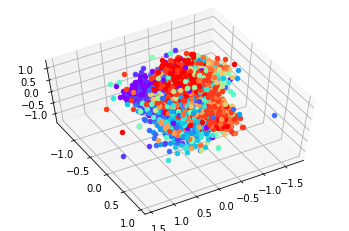

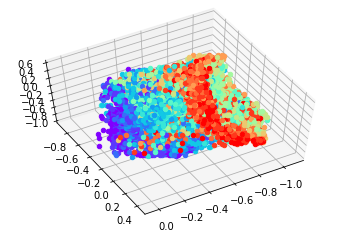

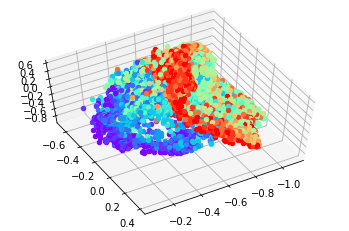

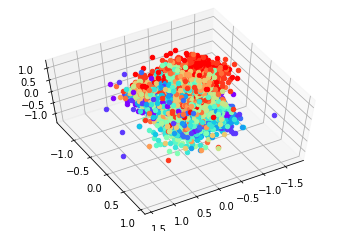

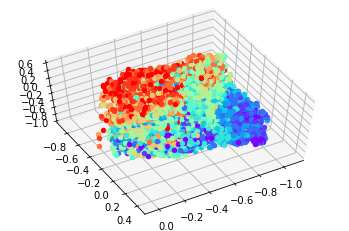

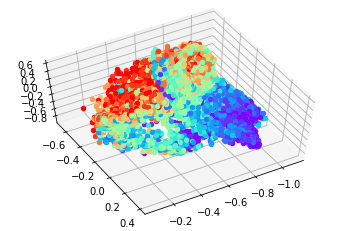

In [29]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][X == x]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][Y == y]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
plt.savefig('manifoldyr10', dpi = 400)  

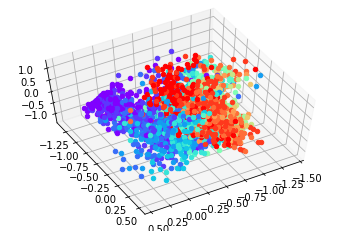

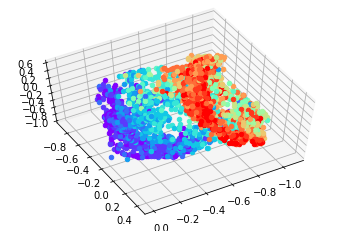

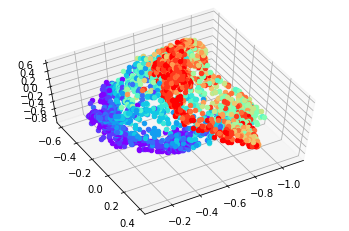

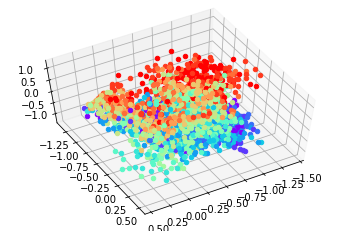

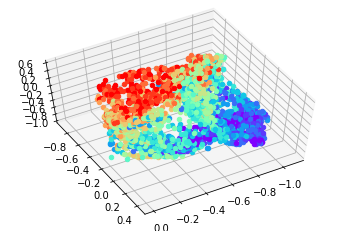

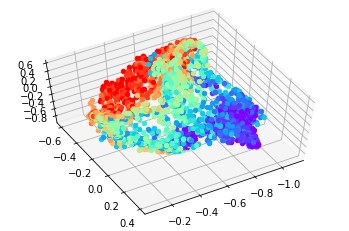

In [32]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldxr0', dpi = 400)

        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
# plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
# plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Stages>=2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
# plt.savefig('manifoldyr10', dpi = 400)      

## separate the position graph into different stimulus groups, see if they orgnaize the same way for different stimulus, also compare after 1 2 3 cicks 

It seems that there are clearly two principle directions, but it is not certain if they overlap or there is shift between different stimulus ,  seems that for y  it is quite clear 

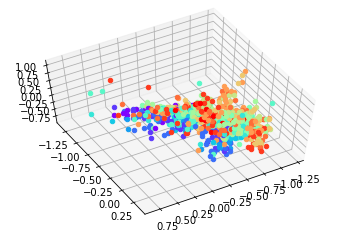

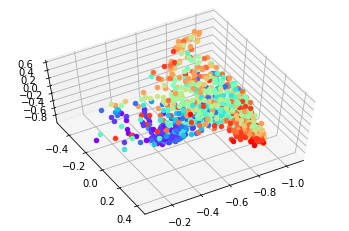

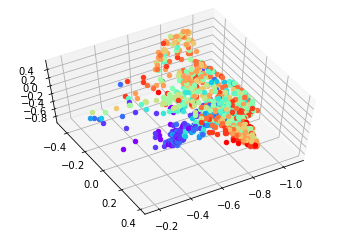

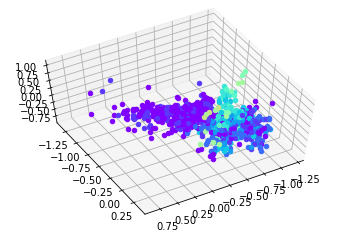

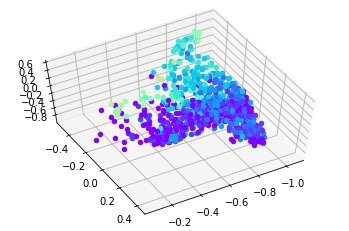

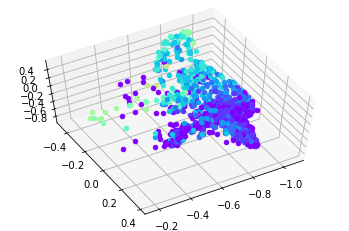

In [25]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 1)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
plt.savefig('manifoldyr10', dpi = 400)          

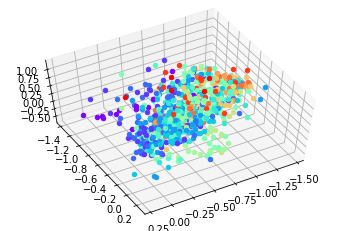

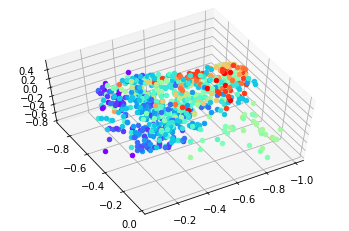

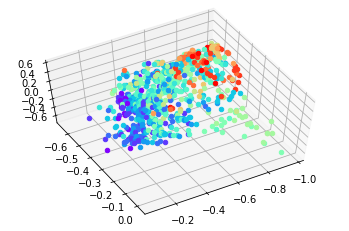

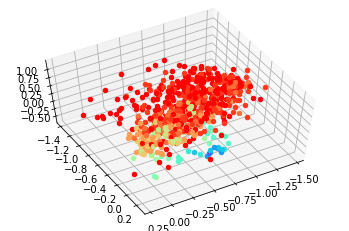

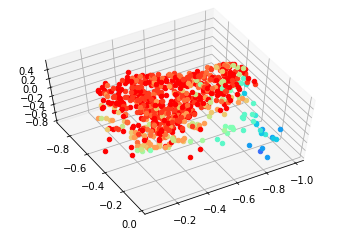

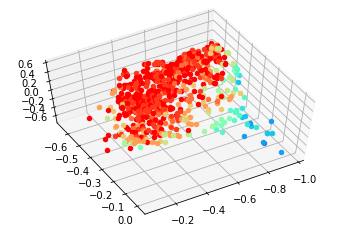

In [26]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 2)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
plt.savefig('manifoldyr10', dpi = 400)          

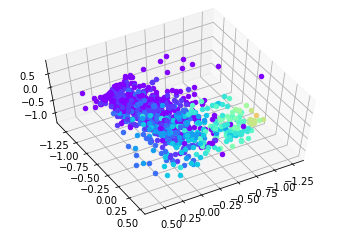

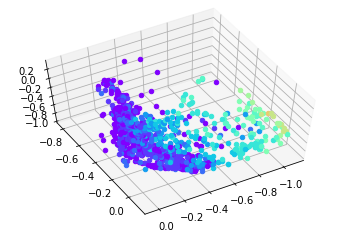

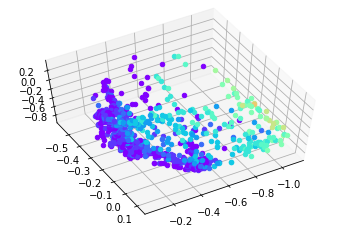

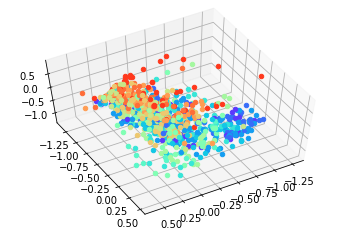

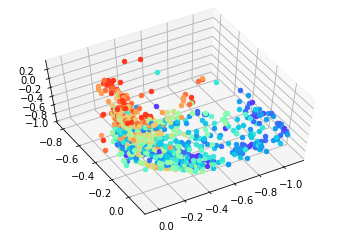

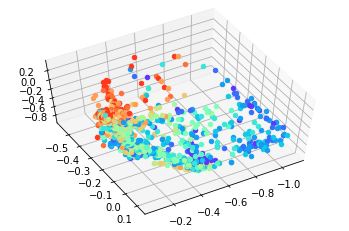

In [27]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 3)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
plt.savefig('manifoldyr10', dpi = 400)          

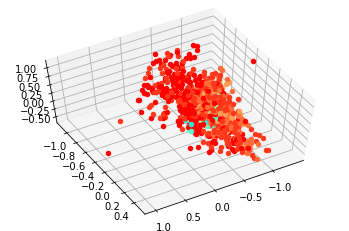

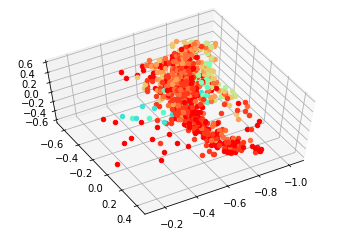

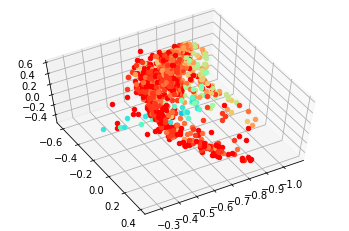

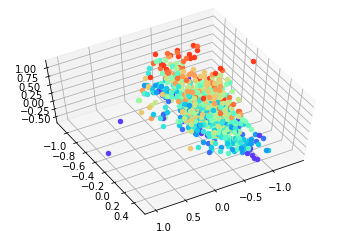

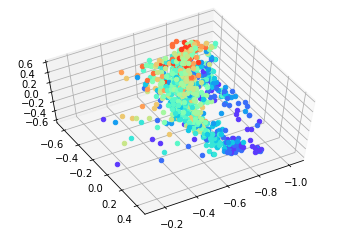

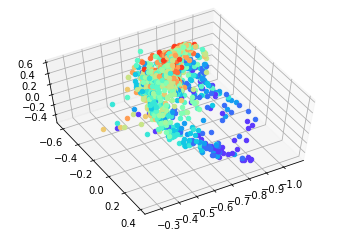

In [28]:
Y = [poss[0] for poss in manifold.Poss]
X = [poss[1] for poss in manifold.Poss]
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(manifold.Hiddens[(X == x) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldxr0', dpi = 400)
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[5][(X == x) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr5', dpi = 400)     
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, x in zip(colors, np.unique(X)):
    for i, hidden in enumerate(Hiddens2[10][(X == x) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldxr10', dpi = 400)
        
Y = [poss[0] for poss in manifold.Poss]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(manifold.Hiddens[(Y == y) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c)
plt.savefig('manifoldyr0', dpi = 400)
        
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[5][(Y == y) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = x)
plt.savefig('manifoldyr5', dpi = 400)  
        
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
for c, y in zip(colors, np.unique(Y)):
    for i, hidden in enumerate(Hiddens2[10][(Y == y) & (manifold.Status == 4)]):
#         plt.figure(0)
        ax.view_init(60, 60)
        ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2], color = c, label = y)    
plt.savefig('manifoldyr10', dpi = 400)          

Take out the 2 cicks points 

Here for the data  prediction part

This is to see if the fit from real hidden states to position and stim could be extended to slow ponts,  seems to be wrong.

The absolute position is sliding, while the relative position kept..

## Input statistics is very important, keep the action noise small will better reveal the internal structure dynamics.  Now the question is what is relation from ring to position it is not clear, it is more like the ring is segmented by the wall not pos

## This part anaylysis shows how the slow relaxation manifold related real game, is the geomotry relation between attractor encoded knowledge of real trace 

If the positions are well segmented, it can be shown by the knn decoder,same for stimulus, we could observe if the position decoding error and stim decoding error are correlated 


**The real game falls into the first one and two PCs quickly after cliking into the wall, means that the PC3 is a fast dimension and the other twos are slow manifold,  which we could define a plane**

In [66]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)

# Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 5)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)

In [67]:
Hiddens2 = Hiddens2.transpose(1, 0, 2)

In [69]:
Hiddens2.shape

(20, 4978, 512)

In [72]:
Hiddens2 = np.vstack([manifold.Hiddens.reshape(1, Hiddens2.shape[1], 512),  Hiddens2])

In [84]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
T  = 50
Distances_x = np.zeros((T, 21))
Distances_y = np.zeros((T, 21))
Memory = []
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.0, T = 1)
    X = np.array([poss[1] for poss in manifold.Poss])
    X2 = np.array([poss[1] for poss in manifold2.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])
    Y2 = np.array([poss[0] for poss in manifold2.Poss])
    # attractor at different relaxation time bins
    for i, attractors in enumerate(Hiddens2):
        distance = []
        distance_x = []
        distance_y = []
        memory = []
        # points in different time of trajectory
        for j, h in enumerate(manifold2.Hiddens):
            v = attractors - h 
            distance.append(np.min(np.linalg.norm(v, axis = 1)))
            index = np.argsort(np.linalg.norm(v, axis = 1))[:20]
            distance_x.append(np.abs(np.mean(X[list(index)]) - X2[j]))
            distance_y.append(np.abs(np.mean(Y[list(index)]) - Y2[j]))
            memory.append((manifold.Status[index[0]], manifold2.Status[j]))
        Distances_x[k, i] = np.mean(distance_x)
        Distances_y[k, i] = np.mean(distance_y)
        Memory.append(memory)

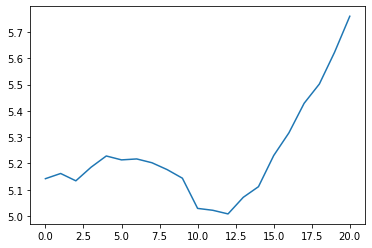

In [85]:
d = np.mean(Distances_x, axis = 0) + np.mean(Distances_y, axis = 0)
plt.plot(d)

In [93]:
Right  = 0
for memory in Memory:
    right = [(m[0] == m[1]) for m in memory]
    Right += (np.sum(right)/len(right))
Right/len(Memory)

0.5147829991538064

In [3]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(300, 0, 6)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)
# transform
Hiddens2 = Hiddens2.transpose(1, 0, 2)
Hiddens2 = np.vstack([manifold.Hiddens.reshape(1, Hiddens2.shape[1], 512),  Hiddens2])

In [11]:
T  = 20
Distances_x = np.zeros((T, 21))
Distances_y = np.zeros((T, 21))
Memory = []
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.0, T = 1)
    X = np.array([poss[1] for poss in manifold.Poss])
    X2 = np.array([poss[1] for poss in manifold2.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])
    Y2 = np.array([poss[0] for poss in manifold2.Poss])
    # attractor at different relaxation time bins
    for i, attractors in enumerate(Hiddens2):
        distance = []
        distance_x = []
        distance_y = []
        memory = []
        # points in different time of trajectory
        for j, h in enumerate(manifold2.Hiddens):
            v = attractors - h 
            distance.append(np.min(np.linalg.norm(v, axis = 1)))
            index = np.argsort(np.linalg.norm(v, axis = 1))[:20]
            distance_x.append(np.abs(np.mean(X[list(index)]) - X2[j]))
            distance_y.append(np.abs(np.mean(Y[list(index)]) - Y2[j]))
#             print (manifold2.Stages[j])
            if int(manifold2.Stages[j])>=1:
                memory.append((manifold.Status[index[0]], manifold2.Status[j]))
        Distances_x[k, i] = np.mean(distance_x)
        Distances_y[k, i] = np.mean(distance_y)
        Memory.append(memory)

In [12]:
manifold2.Stages

array([0. , 0.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. ,
       1.5, 2. ])

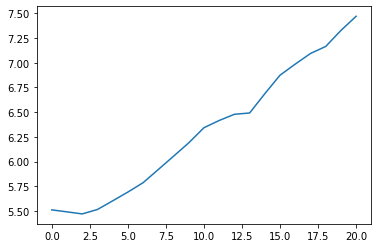

In [13]:
d = np.mean(Distances_x, axis = 0) + np.mean(Distances_y, axis = 0)
plt.plot(d)

In [14]:
from sklearn.metrics import confusion_matrix 
Predicts  = []
Labels = []

for memory in Memory:
    Labels.extend([m[1] for m in memory])
    Predicts.extend([m[0] for m in memory])
#     print (memory)
Labels = np.array(Labels)
Predicts = np.array(Predicts)
confusion_matrix(Labels, Predicts)

array([[  28,   11,    3,   63,    0],
       [ 617,  444,   61,  213,    9],
       [ 191,   62,   11,   55,  374],
       [1202,  360,  188,  788,  276],
       [  29,    6,    5,    0,  191]])

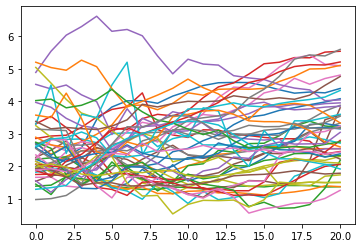

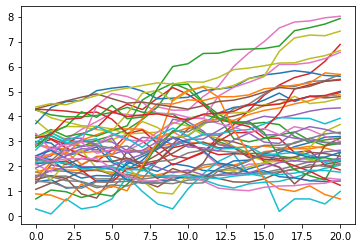

In [93]:
for d in Distances_x:
    plt.plot(d)
plt.figure()
for d in Distances_y:
    plt.plot(d)

In [46]:
np.mean(Distances_x, axis = 0), np.mean(Distances_y, axis = 0)

(array([2.64283805, 2.57271135, 2.5401012 , 2.58681198, 2.61875405,
        2.59685168, 2.63278685, 2.65267007, 2.66984029, 2.66390015,
        2.66716699, 2.69999951, 2.7825203 , 2.82427299, 2.87009052,
        2.91367289, 2.95567181, 2.99614754, 3.04351013, 3.11276705,
        0.        ]),
 array([2.25975865, 2.2540238 , 2.21698587, 2.25491521, 2.2718338 ,
        2.29064916, 2.30653242, 2.28876606, 2.25519698, 2.23762814,
        2.20414311, 2.23834403, 2.2553141 , 2.36495864, 2.51092879,
        2.65670641, 2.80755961, 2.95799117, 3.09137693, 3.16287416,
        0.        ]))

In [95]:
T  = 50
Distances_x = np.zeros((T, 21))
Distances_y = np.zeros((T, 21))
Distances_y = np.zeros((T, 21))
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.0, T = 1)
    X = np.array([poss[1] for poss in manifold.Poss])
    X2 = np.array([poss[1] for poss in manifold2.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])
    Y2 = np.array([poss[0] for poss in manifold2.Poss])
    # attractor at different relaxation time bins
    for i, attractors in enumerate(Hiddens2):
        distance = []
        distance_x = []
        distance_y = []
        # points in different time of trajectory
        for j, h in enumerate(manifold2.Hiddens):
            v = attractors - h 
            distance.append(np.min(np.linalg.norm(v, axis = 1)))
            index = np.argsort(np.linalg.norm(v, axis = 1))[:5]
            distance_x.append(np.abs(np.mean(X[list(index)]) - X2[j]))
            distance_y.append(np.abs(np.mean(Y[list(index)]) - Y2[j]))
        Distances_x[k, i] = np.mean(distance_x)
        Distances_y[k, i] = np.mean(distance_y)

In [96]:
np.mean(Distances_x, axis = 0), np.mean(Distances_y, axis = 0)

(array([2.62622991, 2.57550097, 2.5731254 , 2.47751101, 2.42368036,
        2.40098903, 2.5797938 , 2.60256466, 2.53446603, 2.53171084,
        2.59806045, 2.63623636, 2.70799173, 2.71055092, 2.72056307,
        2.77415903, 2.75926469, 2.73145263, 2.77984643, 2.84935595,
        2.98988601]),
 array([2.67152174, 2.74687782, 2.81823067, 2.89078004, 3.03021405,
        3.05053459, 3.10051684, 3.00502208, 3.0251986 , 3.260876  ,
        3.38350052, 3.37350756, 3.44174457, 3.54032614, 3.56202698,
        3.63598982, 3.73803667, 3.81023368, 3.93010968, 4.13567838,
        4.2675337 ]))

In [97]:
T  = 50
Distances_x = np.zeros((T, 21))
Distances_y = np.zeros((T, 21))
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.0, T = 1)
    X = np.array([poss[1] for poss in manifold.Poss])
    X2 = np.array([poss[1] for poss in manifold2.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])
    Y2 = np.array([poss[0] for poss in manifold2.Poss])
    # attractor at different relaxation time bins
    for i, attractors in enumerate(Hiddens2):
        distance = []
        distance_x = []
        distance_y = []
        # points in different time of trajectory
        for j, h in enumerate(manifold2.Hiddens):
            v = attractors - h 
            distance.append(np.min(np.linalg.norm(v, axis = 1)))
            index = np.argsort(np.linalg.norm(v, axis = 1))[:1]
            distance_x.append(np.abs(np.mean(X[list(index)]) - X2[j]))
            distance_y.append(np.abs(np.mean(Y[list(index)]) - Y2[j]))
        Distances_x[k, i] = np.mean(distance_x)
        Distances_y[k, i] = np.mean(distance_y)

In [98]:
np.mean(Distances_x, axis = 0), np.mean(Distances_y, axis = 0)

(array([3.07771211, 3.4156035 , 3.39018386, 3.81381192, 3.64091085,
        3.99165789, 3.877686  , 3.61102147, 3.58180523, 3.48182088,
        3.61954541, 3.53277963, 3.50196413, 3.47497719, 3.49379957,
        3.69246721, 3.73777431, 3.82645872, 3.86112153, 3.849345  ,
        3.78386288]),
 array([3.23431908, 3.36119549, 3.52207445, 3.46489818, 3.62290096,
        3.83187333, 3.76699402, 4.05018071, 4.4395905 , 4.81303694,
        5.17289849, 5.44190871, 5.46277486, 5.4006182 , 5.2310704 ,
        4.90989708, 4.70336628, 4.36134489, 4.21344116, 4.23300692,
        4.28542654]))

In [36]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 1,  T = 100)
Hidden2, Velocity0, Velocity2, Hiddens2 = manifold.manifold_record(T_slow = 20)
# transform
Hiddens2 = Hiddens2.transpose(1, 0, 2)
Hiddens2 = np.vstack([manifold.Hiddens.reshape(1, Hiddens2.shape[1], 512),  Hiddens2])

In [43]:
Hiddens2.shape

(20, 5149, 512)

In [95]:
T  = 50
Memorys = []
for k in range(T):
    manifold2 = slowmanifold(weight)
    manifold2.data_record(epsilon = 0.5, T = 1)
    # attractor at different relaxation time bins
    attractors= Hiddens2[0]
    memory = []
    # points in different time of trajectory
    for j, h in enumerate(manifold2.Hiddens):
        v = attractors - h 
        index = np.argsort(np.linalg.norm(v, axis = 1))[:20]
        if int(manifold2.Stages[j])>=1:
#             print (manifold2.Status[j], manifold2.Stages[j], manifold2.Poss[j])
            memory.append((manifold.Status[index[0]], manifold2.Status[j]))
    Memorys.append(memory)

In [96]:
# 0 term null zeros indicates reward, where status is 0 but stages are no longer 0 
from sklearn.metrics import confusion_matrix 
Predicts  = []
Labels = []

for memory in Memorys:
    Labels.extend([m[1] for m in memory])
    Predicts.extend([m[0] for m in memory])
#     print (memory)
Labels = np.array(Labels)
Predicts = np.array(Predicts)
confusion_matrix(Labels, Predicts)

array([[  0,   0,   0,   0,   0],
       [ 55,  88,   1,  10,  21],
       [ 33,   0,  23,   9,   2],
       [ 42,  13,   6, 232,   1],
       [ 70,  28,   7,  10,  60]])

### Check for decoding accuracy of each position conditioned on stimulus memory, in order to see if there are any bias.  

In [168]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
def estimate_position(weight, Tr = 20, k = 10, Times = 400, epsilon = 0):
    Distances = []
    Distances_x = []
    Distances_y = []
    Stages = []
    Status = []
    for K in range(Times):
        manifold2 = slowmanifold(weight)
        manifold2.data_record(epsilon = epsilon, T = 1)
        distance = np.zeros((Tr, len(manifold2.Hiddens)))
        distance_x = np.zeros((Tr, len(manifold2.Hiddens)))
        distance_y = np.zeros((Tr, len(manifold2.Hiddens)))
        X = np.array([poss[1] for poss in manifold.Poss])
        X2 = np.array([poss[1] for poss in manifold2.Poss])
        Y = np.array([poss[0] for poss in manifold.Poss])
        Y2 = np.array([poss[0] for poss in manifold2.Poss])
        for tr in range(Tr):
            for i, h in enumerate(manifold2.Hiddens):
#                 attractors0 = [h for h in manifold.Hiddens]
                attractors =  Hiddens2[tr]
#                 v0 = attractors0 - h 
                v = attractors - h 
                distance[tr, i] = np.min(np.linalg.norm(v, axis = 1))
                index = np.argsort(np.linalg.norm(v, axis = 1))[:k]
                distance_x[tr, i] = np.abs(np.mean(X[list(index)]) - X2[i])
                distance_y[tr, i] = np.abs(np.mean(Y[list(index)]) - Y2[i])
        Distances.append(distance)
        Distances_x.append(distance_x)
        Distances_y.append(distance_y)
        Stages.append(manifold2.Stages)
        Status.append(manifold2.Status)
    return Status, Stages, Distances, Distances_x, Distances_y

In [155]:
# select later according to status for pos 
Status, Stages, Distances, Distances_x, Distances_y = estimate_position(weight)

In [90]:
Distances_x[0]

array([[1.1, 1.3, 6.5, 5.1, 1.2, 1.9, 4.2, 3.6, 3.9, 2. , 1.7, 0.9, 0.4,
        0.8, 0.4, 1.1, 2.4],
       [2.5, 1.3, 6. , 6.5, 2. , 2. , 4.2, 2.5, 4.1, 4.3, 1.5, 1.5, 1.9,
        1. , 0.1, 0.1, 2.8],
       [3.5, 3.4, 4.5, 4.9, 3.9, 1.8, 4.1, 3.7, 3.9, 3.7, 1.7, 2.6, 1.6,
        0.4, 1.6, 1.5, 3.9],
       [3.6, 2.6, 4.2, 3.6, 3.3, 2. , 1.8, 3.6, 4.3, 2.6, 1.8, 2.6, 0.6,
        0.2, 1.5, 2.2, 4.5],
       [7.9, 7.4, 7.2, 6.1, 4.4, 1.8, 1.3, 4.9, 4.9, 1.9, 0.8, 0.2, 0.7,
        0.2, 1.4, 3.2, 3.9],
       [6.4, 7.9, 7.5, 6. , 5.6, 3.3, 3.1, 6.2, 5.6, 2.7, 0.6, 0.5, 2.4,
        0.6, 3.3, 3.3, 0.5],
       [7.4, 6.6, 4.6, 3.5, 2.9, 6.2, 4.5, 4.4, 6.1, 3.7, 1. , 0.8, 0.9,
        3.1, 4.4, 3.5, 0.4],
       [4.3, 3.3, 4.2, 3.5, 2.5, 2.7, 6.7, 4. , 3.4, 3.6, 2.2, 1.3, 0.5,
        2.6, 4.5, 3.5, 0.3],
       [2.5, 3.1, 4.2, 3.5, 2.5, 1.5, 2.5, 5.2, 4.2, 2.7, 2.6, 1.5, 0.1,
        2.5, 4.6, 3.5, 1.6],
       [2.3, 3.8, 5.6, 3.3, 2.3, 1.5, 1.5, 2.1, 3. , 2.1, 1.7, 0.9, 0.3,
        2

After getting the stages without influence of reward, the two clicks decoding now increase with relaxation, consistent with visualization 

5.358179455938805 4.1337737869568185 3.914935775105324 400 250 85
5.4160162665821545 4.221671423326038 3.8320284436824217 400 250 85
5.432097603209563 4.217486963505347 3.7641589527350767 400 250 85
5.433700871800812 4.310010650450391 3.7419215135114796 400 250 85
5.377234069366564 4.283300233031773 3.648804163349147 400 250 85
5.412726735969666 4.1485938576242045 3.524270585047401 400 250 85
5.441766477467103 4.070716672784818 3.421004620715694 400 250 85
5.521052569424459 4.016202462570845 3.286151585630825 400 250 85
5.594951310945435 3.98351161579764 3.120975700385735 400 250 85
5.592173615606555 3.905891600073297 2.9725527943797836 399 250 85
5.544686342398852 3.801116273445842 2.8164018107997357 400 250 85
5.52610299997122 3.7618446078033125 2.800846898968006 400 250 85
5.547319934874952 3.786388631761634 2.8352795163314193 400 250 85
5.595776568044437 3.8137098750392466 2.866284192547168 400 250 85
5.679067619392621 3.858281739888656 2.8386559296144074 400 250 85
5.7884623393886

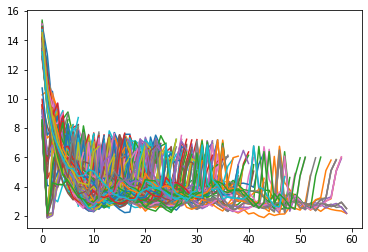

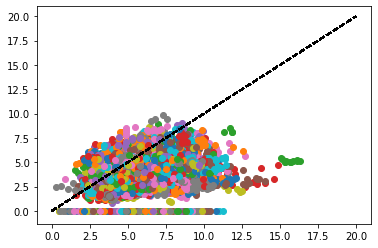

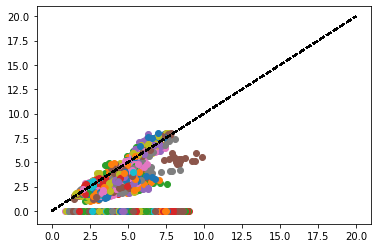

In [156]:
plt.figure(0)
for d in Distances:
    plt.plot(d[0])
D0 = []
D1 = []
D2 = []
for k in range(20):
    E0, E1, E2 = 0, 0, 0
    k0, k1, k2 = 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * (s == 0))/(np.sum(s == 0)+1)
        errx1 = np.sum(dx * (s >=1))/(np.sum(s>=1)+1)
        errx2 = np.sum(dx * (s >=2))/(np.sum(s >=2)+1)
        erry0 = np.sum(dy * (s == 0))/(np.sum(s == 0)+1)
        erry1 = np.sum(dy * (s >=1))/(np.sum(s >=1)+1)
        erry2 = np.sum(dy * (s >=2))/(np.sum(s >=2)+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            E0 += errx0 + erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0 + erry0, errx1 + erry1)
            plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20,  100), 'k--') 
        if errx1 + erry1 != 0:
            E1 += errx1 + erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1 + erry1, errx2 + erry2)
            plt.plot(np.linspace(0, 20, 100), np.linspace(0, 20,  100), 'k--')
        if errx2 + erry2 != 0:
            E2 += errx2 + erry2
            k2 += 1
    print (E0/k0, E1/k1, E2/k2, k0, k1, k2)
    D0.append(E0/k0)
    D1.append(E1/k1)
    D2.append(E2/k2)

Text(0, 0.5, 'decoding error')

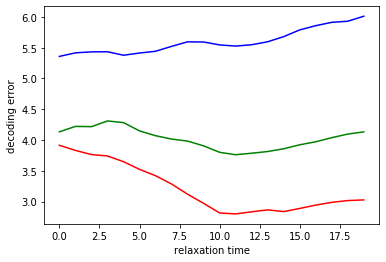

In [157]:
plt.plot(D0, 'b')
plt.plot(D1, 'g')
plt.plot(D2, 'r')
plt.xlabel('relaxation time')
plt.ylabel('decoding error')

This analysis is to reveal after each clck if it only remembers position related to the wall, or it is a 2D objects which related to both.     

3.3448860878206146 1.4917112140786697 2.707258649159517 2.314137534913666 2.2857082149993797 2.336888307023748 1.752023966814614 1.716478631813424
2.952022775527335 1.8485304782453755 2.6462806509982104 2.649311269697009 2.321665313793628 2.3802127339819013 2.115836140294726 1.659343704148701
2.666195707976257 2.0480070975209888 2.7625705980403525 2.7581073307583663 2.087589753558821 2.445335730559404 2.172149948713377 1.601095912024442
2.548153433349674 2.1381477961366495 2.6689733301842344 2.2269688411314967 1.9343809962675962 2.5177686430930537 2.2398845047668847 1.5212119061668
2.4367685392726557 2.3280686593345354 2.663388068177065 1.964771559044445 1.8113498840569895 2.6422744569314047 2.0702415552882734 1.5263396458033767
2.3679619566794363 2.194003905643262 2.319151781669579 1.9868698320700833 1.6489941917407058 2.7420268642490178 1.931559094225684 1.5587565808613117
2.4480143650178285 2.041629050766414 2.2298157741286326 1.9442751093237864 1.4242991669525098 2.864781341879694 

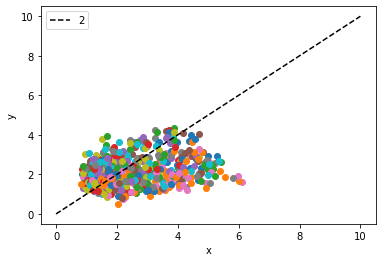

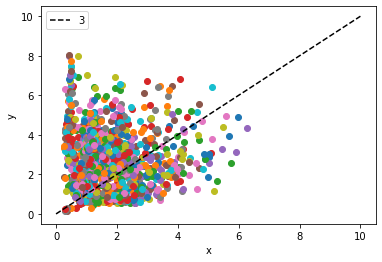

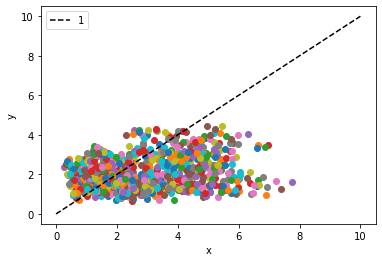

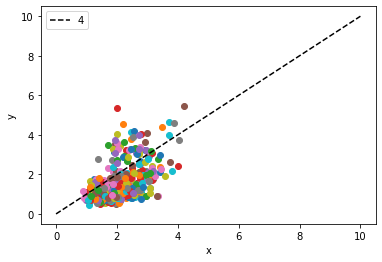

In [166]:
D0 = []
D1 = []
D2 = []
for k in np.arange(0, 20, 2):
    Ex0, Ex1, Ex2, Ex3 = 0, 0, 0, 0
    Ey0, Ey1, Ey2, Ey3 = 0, 0, 0, 0
    k0, k1, k2, k3 = 0, 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * (m == 1))/(np.sum(m == 1)+1)
        errx1 = np.sum(dx * (m == 2))/(np.sum(m == 2)+1)
        errx2 = np.sum(dx * (m == 3))/(np.sum(m == 3)+1)
        errx3 = np.sum(dx * (m == 4))/(np.sum(m == 4)+1)
        erry0 = np.sum(dy * (m == 1))/(np.sum(m == 1)+1)
        erry1 = np.sum(dy * (m == 2))/(np.sum(m == 2)+1)
        erry2 = np.sum(dy * (m == 3))/(np.sum(m == 3)+1)
        erry3 = np.sum(dy * (m == 4))/(np.sum(m == 4)+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            Ex0 += errx0
            Ey0 += erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0, erry0)
     
        if errx1 + erry1 != 0:
            Ex1 += errx1
            Ey1 += erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1, erry1)
        if errx2 + erry2 != 0:
            Ex2 += errx2 
            Ey2 += erry2
            k2 += 1
            plt.figure(3)
            plt.scatter(errx2, erry2)

        if errx3 + erry3 != 0:
            Ex3 += errx3 
            Ey3 += erry3
            k3 += 1
            plt.figure(4)
            plt.scatter(errx3, erry3)
          
    print (Ex0/k0, Ey0/k0, Ex1/k1, Ey1/k1, Ex2/k2, Ey2/k2, Ex3/k3, Ey3/k3)
for k in np.arange(1, 5, 1):
    plt.figure(k)
    plt.plot(np.linspace(0, 10, 100), np.linspace(0, 10,  100), 'k--', label = k) 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

After two clicks, it could be shown that for each memory state there is good decoding of both x, y, suggesting a plane attractors behind, the next question will be, if we write 
x = k1 PC1 + k2PC2, or PC = k1x + k2y, are the coefcient based on different history same or different  

3.0335109126984117 0.717642857142857 3.521323802460165 1.9569345301163479 1.2261742424242423 2.0466287878787877 1.395292624042624 1.3390401265401266
2.680078373015873 0.889224206349206 3.3403159592932328 2.1653460680733403 1.1390873015873015 2.1466107503607503 1.4454899267399266 1.2897947885447885
2.38145734126984 1.0704424603174603 3.0815737923692477 2.38404563870473 1.2233964646464646 2.163293650793651 1.5611371961371963 1.1793027805527805
2.1998025793650795 1.1934444444444448 3.0446258539440354 2.483302820916457 1.1756890331890333 2.2333170995670995 1.57996336996337 1.1158641358641357
1.991127976190476 1.2124662698412698 3.082935461003643 2.5484049662458754 1.209332611832612 2.084825036075036 1.5107742257742258 1.1054820179820182
1.9249216269841274 1.2226795634920637 2.9651840709795256 2.394137264250901 1.1554076479076478 1.9928012265512265 1.5486896436896436 1.043967282717283
1.8832678571428567 1.272407738095238 2.8355563880563883 2.13673297661934 1.1947835497835497 1.9688906926406

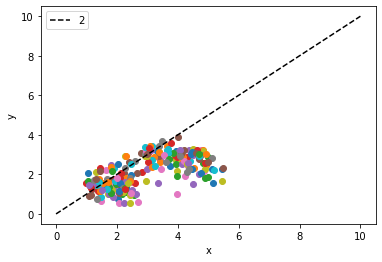

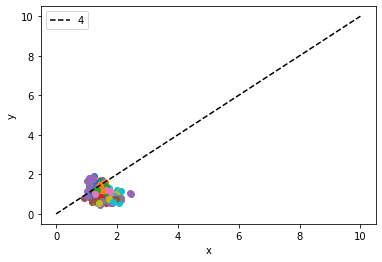

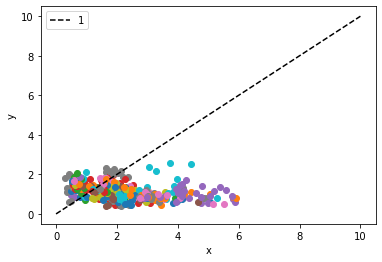

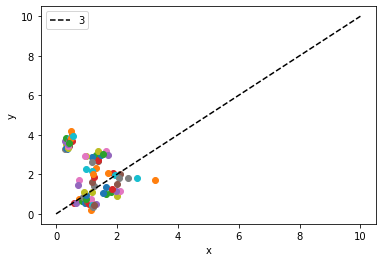

In [167]:
D0 = []
D1 = []
D2 = []
for k in range(10):
    Ex0, Ex1, Ex2, Ex3 = 0, 0, 0, 0
    Ey0, Ey1, Ey2, Ey3 = 0, 0, 0, 0
    k0, k1, k2, k3 = 0, 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * ((m == 1) & (s>=2)))/(np.sum((m == 1) & (s>=2))+1)
        errx1 = np.sum(dx * ((m == 2) & (s>=2)))/(np.sum((m == 2) & (s>=2))+1)
        errx2 = np.sum(dx * ((m == 3) & (s>=2)))/(np.sum((m == 3) & (s>=2))+1)
        errx3 = np.sum(dx * ((m == 4) & (s>=2)))/(np.sum((m == 4) & (s>=2))+1)
        erry0 = np.sum(dy * ((m == 1) & (s>=2)))/(np.sum((m == 1) & (s>=2))+1)
        erry1 = np.sum(dy * ((m == 2) & (s>=2)))/(np.sum((m == 2) & (s>=2))+1)
        erry2 = np.sum(dy * ((m == 3) & (s>=2)))/(np.sum((m == 3) & (s>=2))+1)
        erry3 = np.sum(dy * ((m == 4) & (s>=2)))/(np.sum((m == 4) & (s>=2))+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            Ex0 += errx0
            Ey0 += erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0, erry0)
     
        if errx1 + erry1 != 0:
            Ex1 += errx1
            Ey1 += erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1, erry1)
        if errx2 + erry2 != 0:
            Ex2 += errx2 
            Ey2 += erry2
            k2 += 1
            plt.figure(3)
            plt.scatter(errx2, erry2)

        if errx3 + erry3 != 0:
            Ex3 += errx3 
            Ey3 += erry3
            k3 += 1
            plt.figure(4)
            plt.scatter(errx3, erry3)
          
    print (Ex0/k0, Ey0/k0, Ex1/k1, Ey1/k1, Ex2/k2, Ey2/k2, Ex3/k3, Ey3/k3)
    D0.append(E0/k0)
    D1.append(E1/k1)
    D2.append(E2/k2)
for k in np.arange(1, 5, 1):
    plt.figure(k)
    plt.plot(np.linspace(0, 10, 100), np.linspace(0, 10,  100), 'k--', label = k) 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

In [ ]:
# more noise , more random fluctuation, see effect  
Status, Stages, Distances, Distances_x, Distances_y = estimate_position(weight, epsilon = 0.5)
D0 = []
D1 = []
D2 = []
for k in range(10):
    Ex0, Ex1, Ex2, Ex3 = 0, 0, 0, 0
    Ey0, Ey1, Ey2, Ey3 = 0, 0, 0, 0
    k0, k1, k2, k3 = 0, 0, 0, 0
    for dX, dY, s, m in zip(Distances_x, Distances_y, Stages, Status):
        dx, dy = dX[k], dY[k]
        errx0 = np.sum(dx * ((m == 1) & (s>=2)))/(np.sum((m == 1) & (s>=2))+1)
        errx1 = np.sum(dx * ((m == 2) & (s>=2)))/(np.sum((m == 2) & (s>=2))+1)
        errx2 = np.sum(dx * ((m == 3) & (s>=2)))/(np.sum((m == 3) & (s>=2))+1)
        errx3 = np.sum(dx * ((m == 4) & (s>=2)))/(np.sum((m == 4) & (s>=2))+1)
        erry0 = np.sum(dy * ((m == 1) & (s>=2)))/(np.sum((m == 1) & (s>=2))+1)
        erry1 = np.sum(dy * ((m == 2) & (s>=2)))/(np.sum((m == 2) & (s>=2))+1)
        erry2 = np.sum(dy * ((m == 3) & (s>=2)))/(np.sum((m == 3) & (s>=2))+1)
        erry3 = np.sum(dy * ((m == 4) & (s>=2)))/(np.sum((m == 4) & (s>=2))+1)
    #     print (errx0 + erry0, errx1 + erry1, errx2 + erry2)
        if errx0 + erry0 != 0:
            Ex0 += errx0
            Ey0 += erry0
            k0 += 1
            plt.figure(1)
            plt.scatter(errx0, erry0)
     
        if errx1 + erry1 != 0:
            Ex1 += errx1
            Ey1 += erry1
            k1 += 1
            plt.figure(2)
            plt.scatter(errx1, erry1)
        if errx2 + erry2 != 0:
            Ex2 += errx2 
            Ey2 += erry2
            k2 += 1
            plt.figure(3)
            plt.scatter(errx2, erry2)

        if errx3 + erry3 != 0:
            Ex3 += errx3 
            Ey3 += erry3
            k3 += 1
            plt.figure(4)
            plt.scatter(errx3, erry3)
          
    print (Ex0/k0, Ey0/k0, Ex1/k1, Ey1/k1, Ex2/k2, Ey2/k2, Ex3/k3, Ey3/k3)
    D0.append(E0/k0)
    D1.append(E1/k1)
    D2.append(E2/k2)
for k in np.arange(1, 5, 1):
    plt.figure(k)
    plt.plot(np.linspace(0, 10, 100), np.linspace(0, 10,  100), 'k--', label = k) 
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()

## construct h = f(x, y, s) 
Explore hs = k1x + k2y + b 
is k1, k2, b same ?  
In order to see if each stimulus has the same or differen spatial map,  we use hiddens of all recordings, split into four stimulus, use the linear regression to map each of them 

In [159]:
Hiddens2.shape

(20, 5149, 512)

In [160]:
D0 = []
D1 = []
D2 = []
X = np.array([poss[1] for poss in manifold.Poss])
Y = np.array([poss[0] for poss in manifold.Poss])

PCs = []
Xs = []
Ys = []
for H, s, m, x, y in zip(Hiddens2[5], manifold.Status, manifold.Stages, X, Y):
    Hs = H[(m == 1) & (s>=2)]
    xs = x[(m == 1) & (s>=2)]
    ys = y[(m == 1) & (s>=2)]
    PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
    Xs.extend(xs)
    Ys.extend(ys)

PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
print (Pos.shape, PCs.shape)

clf = sklearn.linear_model.LinearRegression()
clf.fit(Pos, PCs)
clf.coef_, clf.intercept_

(291, 2) (291, 3)


array([[-0.03131636,  0.01828927],
       [ 0.00424795, -0.01928882],
       [ 0.04849255,  0.03894454]])

In [161]:
D0 = []
D1 = []
D2 = []
X = np.array([poss[1] for poss in manifold.Poss])
Y = np.array([poss[0] for poss in manifold.Poss])

PCs = []
Xs = []
Ys = []
for H, s, m, x, y in zip(Hiddens2[5], manifold.Status, manifold.Stages, X, Y):
    Hs = H[(m == 2) & (s>=2)]
    xs = x[(m == 2) & (s>=2)]
    ys = y[(m == 2) & (s>=2)]
    PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
    Xs.extend(xs)
    Ys.extend(ys)
PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
print (Pos.shape, PCs.shape)

clf = sklearn.linear_model.LinearRegression()
clf.fit(Pos, PCs)
clf.coef_, clf.intercept_

(230, 2) (230, 3)


array([[-0.03766047,  0.00050172],
       [ 0.01071615, -0.03601951],
       [ 0.03848168,  0.03528142]])

In [150]:
D0 = []
D1 = []
D2 = []
X = np.array([poss[1] for poss in manifold.Poss])
Y = np.array([poss[0] for poss in manifold.Poss])

PCs = []
Xs = []
Ys = []
for H, s, m, x, y in zip(Hiddens2[5], manifold.Status, manifold.Stages, X, Y):
    Hs = H[(m == 3) & (s>=2)]
    xs = x[(m == 3) & (s>=2)]
    ys = y[(m == 3) & (s>=2)]
    PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
    Xs.extend(xs)
    Ys.extend(ys)
PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
print (Pos.shape, PCs.shape)

clf = sklearn.linear_model.LinearRegression()
clf.fit(Pos, PCs)
clf.coef_, clf.intercept_

(260, 2) (260, 3)


array([[-0.03590185,  0.0007195 ],
       [ 0.00164113, -0.03746827],
       [ 0.06277585,  0.05696791]])

In [151]:
D0 = []
D1 = []
D2 = []
X = np.array([poss[1] for poss in manifold.Poss])
Y = np.array([poss[0] for poss in manifold.Poss])

PCs = []
Xs = []
Ys = []
for H, s, m, x, y in zip(Hiddens2[5], manifold.Status, manifold.Stages, X, Y):
    Hs = H[(m == 4) & (s>=2)]
    xs = x[(m == 4) & (s>=2)]
    ys = y[(m == 4) & (s>=2)]
    PCs.extend(np.dot(Hs, manifold.pca.vect[:3].T))
    Xs.extend(xs)
    Ys.extend(ys)
PCs, Xs, Ys = np.array(PCs), np.array(Xs), np.array(Ys)
Pos = np.concatenate([Xs.reshape(-1, 1), Ys.reshape(-1, 1)], axis = 1)
print (Pos.shape, PCs.shape)

clf = sklearn.linear_model.LinearRegression()
clf.fit(Pos, PCs)
clf.coef_, clf.intercept_

(253, 2) (253, 3)


array([[-0.03756056,  0.00285759],
       [ 0.00054196, -0.03635442],
       [ 0.05658081,  0.06526255]])

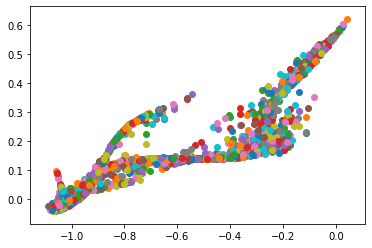

In [58]:
# check with manifold with smaller noise level 
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(399, 0, 9)
manifold = slowmanifold(weight)
manifold.pca_record()
manifold.data_record(epsilon = 0.1,  T = 100)
Hidden10, Velocity0, Velocity1 = manifold.manifold_record(T_slow = 10)
Hidden2, Velocity0, Velocity2 = manifold.manifold_record(T_slow = 50)
for i in range(len(Hidden10)):
    plt.scatter(Hidden2[i].data.numpy() @ manifold.pca.vect[0],\
                Hidden2[i].data.numpy() @ manifold.pca.vect[1])

39
59
15
17
27
40


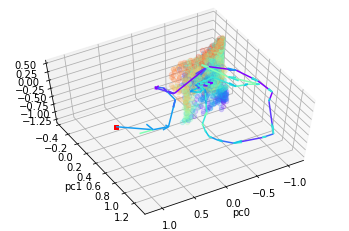

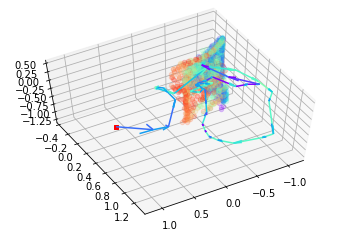

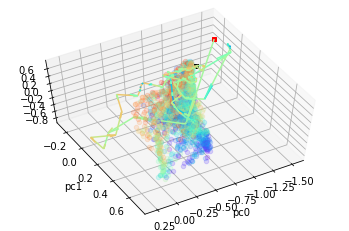

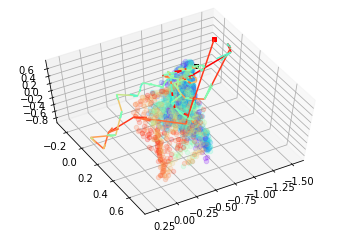

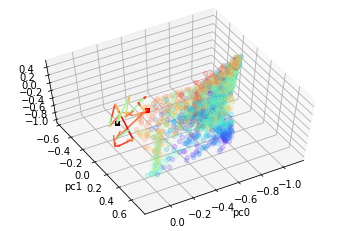

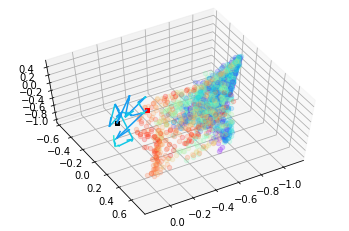

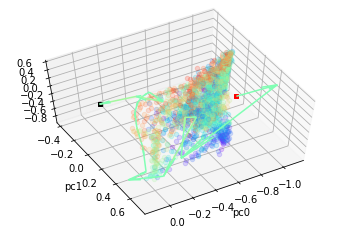

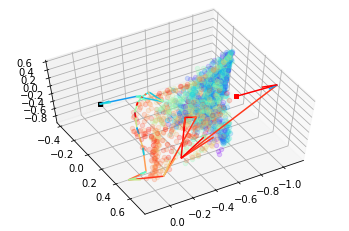

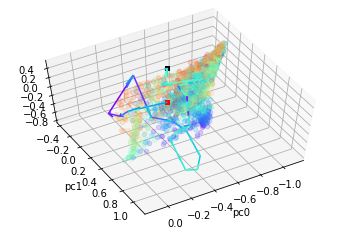

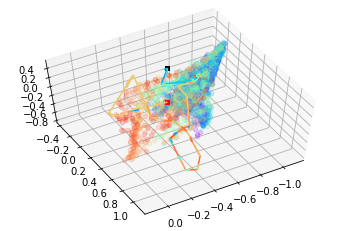

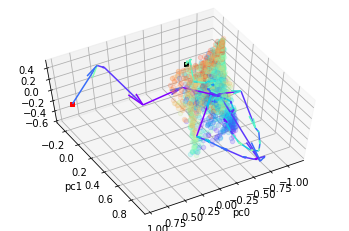

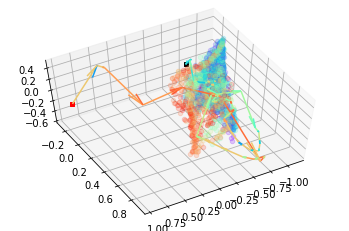

In [61]:
weight = 'weights_basic_pos2/rnn_1515tanh512_checkpoint{}_{}_{}'.format(300, 0, 6)
for K in range(6):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    manifold2 = slowmanifold(weight)
    manifold2.pca_record()
    manifold2.data_record(epsilon = 0.5, T = 1)
    PC0 = []
    PC1 = []
    PC2 = []
    X = [poss[1] for poss in manifold.Poss]
    X2 = [poss[1] for poss in manifold2.Poss]
    Y = [poss[0] for poss in manifold.Poss]
    Y2 = [poss[0] for poss in manifold2.Poss]
    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
    Colors = []
    Hidden1, Velocity0, Velocity1 = manifold2.manifold_record(T_slow = 10)
    for i, hidden in enumerate(manifold2.Hiddens):
        ax.view_init(60, 60)
#         ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
#                    hidden @ manifold.pca.vect[2], color = colors[k])
        PC0.append(hidden @ manifold.pca.vect[0])
        PC1.append(hidden @ manifold.pca.vect[1])
        PC2.append(hidden @ manifold.pca.vect[2])
        Colors.append(colors[Y2[i]-2])
        if i == 0:
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2],\
                      marker = 's', color = 'r')
    ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2],\
                      marker = 's', color = 'k')
    PC0 = np.array(PC0)
    PC1 = np.array(PC1)
    PC2 = np.array(PC2)
    U = PC0[1:] - PC0[:-1]
    V = PC1[1:] - PC1[:-1]
    W = PC2[1:] - PC2[:-1]

    ax.quiver(PC0[:-1], PC1[:-1], PC2[:-1], U, V, W,  color = Colors, alpha = 1)
    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(Y))))
    for i, hidden in enumerate(Hidden10):
        ax.view_init(60, 60)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], hidden[0].data.numpy() @ manifold.pca.vect[1], hidden[0].data.numpy() @ manifold.pca.vect[2],\
                   color = colors[Y[i]-2], alpha = 0.2)
    plt.xlabel('pc0')
    plt.ylabel('pc1')
    
    # draw x 
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
    Colors = []
    PC0 = []
    PC1 = []
    PC2 = []
    Hidden1, Velocity0, Velocity1 = manifold2.manifold_record(T_slow = 10)
    for i, hidden in enumerate(manifold2.Hiddens):
        ax.view_init(60, 30)
#         ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1],
#                    hidden @ manifold.pca.vect[2], color = colors[k])
        PC0.append(hidden @ manifold.pca.vect[0])
        PC1.append(hidden @ manifold.pca.vect[1])
        PC2.append(hidden @ manifold.pca.vect[2])
        Colors.append(colors[X2[i]-2])
        if i == 0:
            ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2],\
                      marker = 's', color = 'r')
    ax.scatter(hidden @ manifold.pca.vect[0], hidden @ manifold.pca.vect[1], hidden @ manifold.pca.vect[2],\
                  marker = 's', color = 'k')
    PC0 = np.array(PC0)
    PC1 = np.array(PC1)
    PC2 = np.array(PC2)
    U = PC0[1:] - PC0[:-1]
    V = PC1[1:] - PC1[:-1]
    W = PC2[1:] - PC2[:-1]
    print (len(W))
    ax.quiver(PC0[:-1], PC1[:-1], PC2[:-1], U, V, W,  color = Colors, alpha = 1)
    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(X))))
    for i, hidden in enumerate(Hidden10):
        ax.view_init(60, 60)
        ax.scatter(hidden[0].data.numpy() @ manifold.pca.vect[0], \
                   hidden[0].data.numpy() @ manifold.pca.vect[1], \
                   hidden[0].data.numpy() @ manifold.pca.vect[2], \
                   color = colors[X[i]-2], alpha = 0.2)
    plt.savefig('dynamics_pos2{}'.format(6+K), dpi = 400)    

calculate distance from point to line 

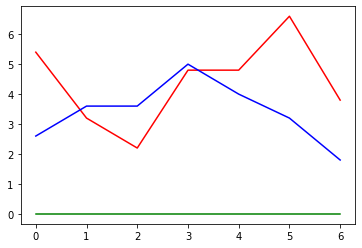

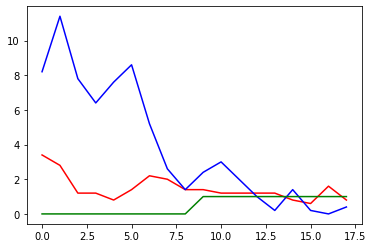

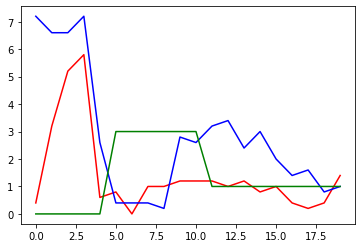

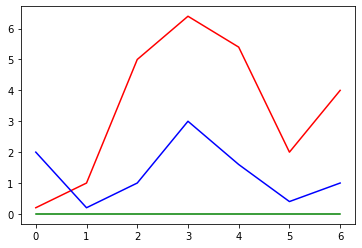

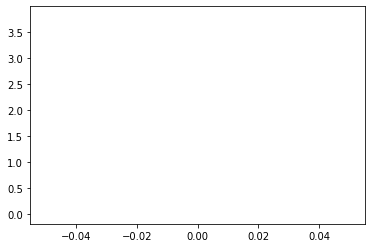

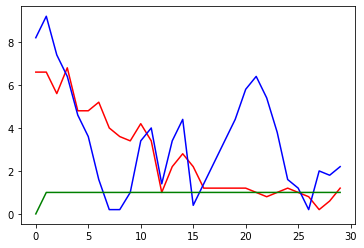

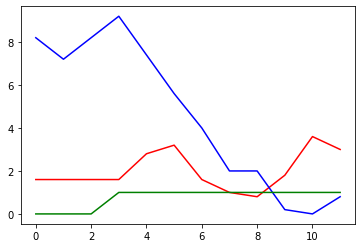

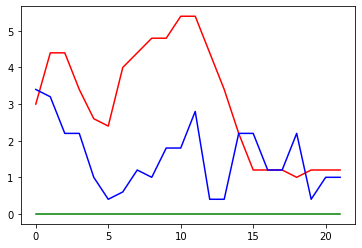

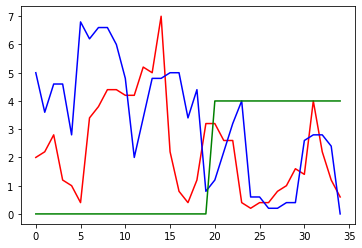

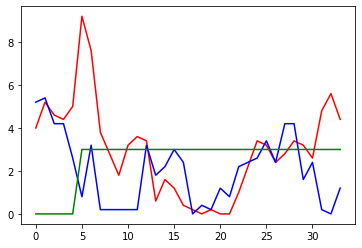

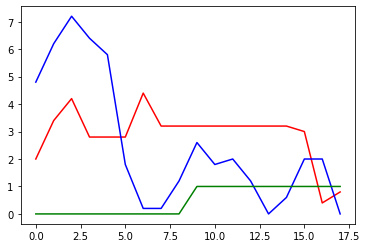

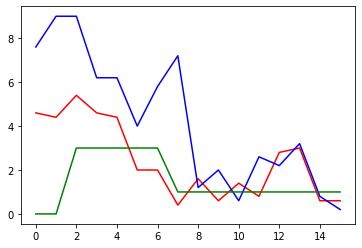

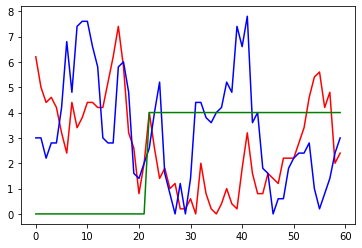

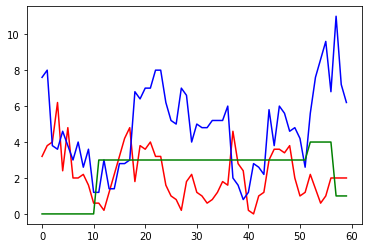

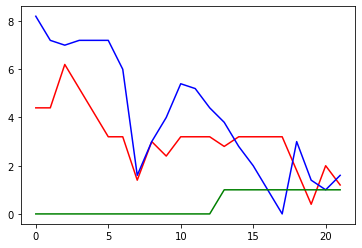

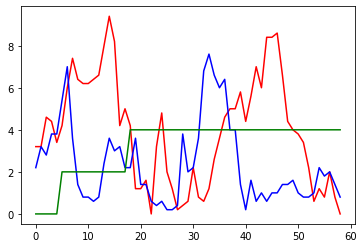

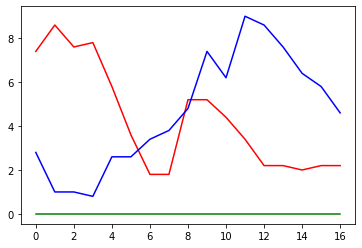

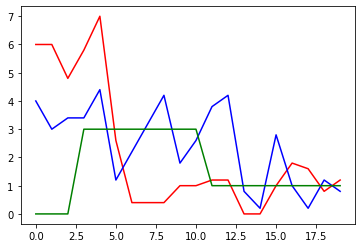

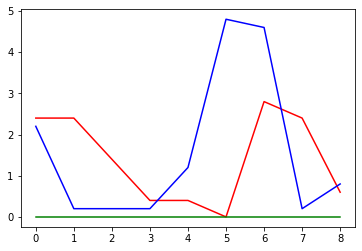

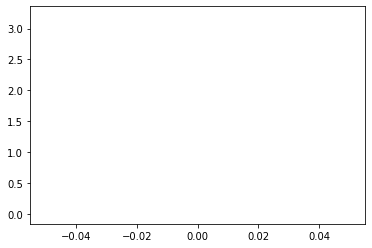

In [103]:
for k in range(20):
    manifold2.data_record(epsilon = 0.0, T = 1)
    distance = []
    distance_x = []
    distance_y = []
    X = np.array([poss[1] for poss in manifold.Poss])
    X2 = np.array([poss[1] for poss in manifold2.Poss])
    Y = np.array([poss[0] for poss in manifold.Poss])
    Y2 = np.array([poss[0] for poss in manifold2.Poss])
    for i, h in enumerate(manifold2.Hiddens):
        attractors = [h[0].data.numpy() for h in Hidden10]
        v = attractors - h 
        distance.append(np.min(np.linalg.norm(v, axis = 1)))
        index = np.argsort(np.linalg.norm(v, axis = 1))[:5]
#         if manifold2.Status[i] in [1,  3]:
#         print (np.mean(X[list(index)]), X2[i], np.mean(Y[list(index)]), Y2[i])
#         if manifold2.Status[i] in [2,  4]:
#             print (np.mean(X[list(index)]), X2[i], np.mean(Y[list(index)]), Y2[i])
        distance_x.append(np.abs(np.mean(X[list(index)]) - X2[i]))
        distance_y.append(np.abs(np.mean(Y[list(index)]) - Y2[i]))
    plt.figure()
    plt.plot(distance_x, 'r')
    plt.plot(distance_y, 'b')
    plt.plot(manifold2.Status, 'g')

### Summary

**0 The strategy is directly reflecting the internal dynamics**

**1 The ability to model the external world lies in richness of internal dynamics, for example the distribution of timescales forms during the pretraining**

**2 To characterize the rich internal timescales , there are 5 features, 1,  the ratio limit cycle/fix point 2,  the mean of relaxation time to fix point 3, the variance of relaxation timescale to fix point  4, the distribution of timescales of limit cycles 5,  The multi-stablity from stimulus**

**3 The performance are : extrapolation performance(small, large),  intrapolation performance(small , middle , large),  learning speed, learning stability,  Try to to connect the 5 features of dynamics to the performance metrix**

**4, Until now ratio limit cycle/fix point during the close loop form seems to indicates best the performance but with noise.**  


**what is the relation between close loop and open loop analysis?**

longer time, there is no pheonmean associate with multi-stability

Here with action feedback, dynamics shift to a totally different regime which is around hopf bifurcation, but it is not hugely shaped by the stimulus

From this graph of PC, we will see that the representation states of trajectory (3,5) and (14,5) are actually qutie close to each other , reflecting symmetry in real space, it is in spirit of predictive decoding, using least number of interal states to play well. 

# Conclusion
**Internal dynamics rather than decoding performance influences more the performance in uncertain enviroments**

**Consider to think in global loops rather than separated system, thus the coupled dynamical system.  This system, which has its genome on its internal weights, will have quite different different pheno-types from the global loops,  richness of internal dynamics turns into extenable phenotypes which supports behaviours across scales.   The different types of attractors, fix point, limit cycle becomes substrate of strategy in different size rooms.  Thus generalization can be done until certain size, which offers complicate behaviour with a "simple mind"**

**The triangle between decoding, dynamics and navigation should be like: 1, dynamics coded by internal weight is most fundamental, it gives rise to different representations(phenotypes).   2,  The relation between decoding and navigation are reciprocal. not random behaviour gives better enviromental prediction(complement the free energy principle) 2,  we should distinguish internal dynamics and global dynamics**